In [176]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

In [177]:
def beam_waist(z, w0, zmin, zR):
    """
    Calculate the beam waist as a function of distance z from the beam waist.
    Parameters:
    z : array-like
        Distance from the beam waist.
    w0 : float
        Minimum beam waist (at z = zmin).
    zmin : float
        Position of the beam waist (where w = w0).
    zR : float
        Rayleigh range (distance over which the beam waist increases by a factor of sqrt(2
        from its minimum value).
    Returns:
    w : array-like
        Beam waist at distance z.
    """
    return 2 * w0 * np.sqrt(1 + ((z - zmin) / zR)**2)

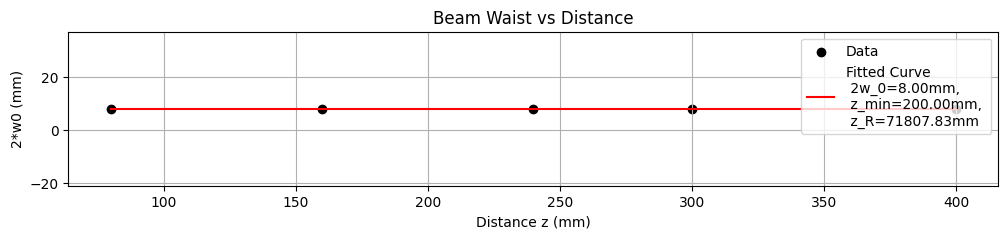

In [178]:
z = np.array([80, 160, 240, 300, 400])  # Example data for distance from a refrence point in mm
w0 = 4  # Example minimum beam waist in mm
lam = 700e-6  # Wavelength of the light in mm
zR = np.pi * w0**2 / lam  # Calculate the Rayleigh range
z_min = 200  # Example position of the beam waist in mm
# Example data for 2*w0 in mm with noise
two_w0 = beam_waist(z, w0, z_min, zR) # + np.random.normal(0, 0.01, 5)  # Add some noise

# plot the data
plt.figure(figsize=(12, 2))
plt.scatter(z, two_w0, label='Data', color='black')
# Fit the curve to the data
popt, pcov = curve_fit(beam_waist, z, two_w0, p0=[w0, z_min, zR])
w0, zmin, zR = popt
# Generate a smooth curve for plotting
z_fit = np.linspace(min(z), max(z), 100)
two_w0_fit = beam_waist(z_fit, *popt)
# Plot the fitted curve
plt.plot(z_fit, two_w0_fit, label=f'Fitted Curve \n 2w_0={2*w0:.2f}mm, \n z_min={zmin:.2f}mm, \n z_R={zR:.2f}mm', color='red')
plt.xlabel('Distance z (mm)')
plt.ylabel('2*w0 (mm)')
plt.title('Beam Waist vs Distance')
plt.legend()
plt.axis('equal')
plt.grid()
plt.show()

In [179]:
z_lens = 400 # location of the lens in mm
f = 150 # focal length of the converging lens in mm
q1 = z_lens - zmin + 1j * zR # complex beam parameter before the lens
q2 = 1 / (1 / q1 - 1 / f) # complex beam parameter after the lens
w0_after_lens = np.sqrt(lam * np.imag(q2) / np.pi) # new beam waist after the lens
print(f"New beam waist after the lens: {2e3 * w0_after_lens:.2f} um")
z_min_after_lens = z_lens - np.real(q2) # new position of the beam waist after the lens
print(f"New position of the beam waist after the lens: {z_min_after_lens:.2f} mm")
print(f"Rayleigh range after the lens: {1e3 * np.imag(q2):.2f} um")

New beam waist after the lens: 16.71 um
New position of the beam waist after the lens: 550.00 mm
Rayleigh range after the lens: 313.34 um


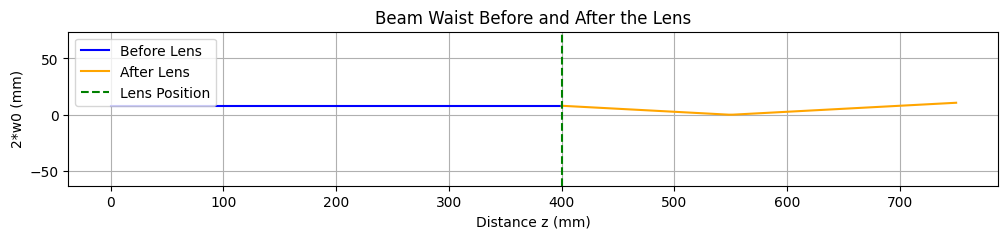

In [183]:
z_before_lens = np.linspace(zmin - 200, z_lens, 100)
z_after_lens = np.linspace(z_lens, z_min_after_lens + 200, 100)
two_w0_before_lens = beam_waist(z_before_lens, w0, zmin, np.imag(q1))
two_w0_after_lens = beam_waist(z_after_lens, w0_after_lens, z_min_after_lens, np.imag(q2))
plt.figure(figsize=(12, 2))
plt.plot(z_before_lens, two_w0_before_lens, label='Before Lens', color='blue')
plt.plot(z_after_lens, two_w0_after_lens, label='After Lens', color='orange')
plt.axvline(x=z_lens, color='green', linestyle='--', label='Lens Position')
plt.xlabel('Distance z (mm)')
plt.ylabel('2*w0 (mm)')
plt.title('Beam Waist Before and After the Lens')
plt.legend()
plt.axis('equal')
plt.grid()
plt.show()

In [181]:
z = np.real(q1)
w0 = np.sqrt(lam * np.imag(q1) / np.pi)
beam_waist(z, w0, 0, np.imag(q1))

np.float64(8.00003102955231)

In [182]:
np.imag(q1) - zR

np.float64(0.0)

beam start: z=0.00 mm, w0=0.67 mm
converging lens, f = 100 mm: z=-100.00 mm, w0=0.13 mm
converging lens f = 200 mm: z=-200.00 mm, w0=1.34 mm
beam end: z=0.00 mm, w0=1.34 mm


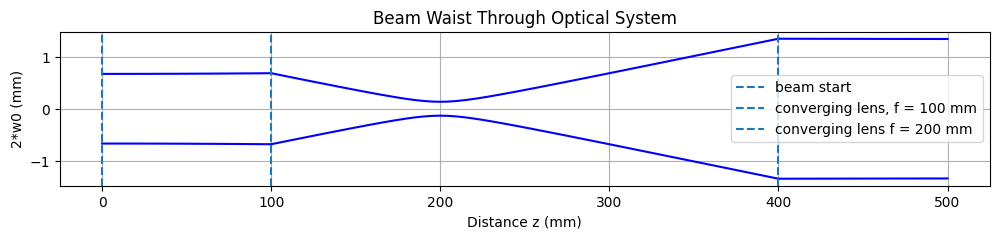

In [208]:
el_pos_z = np.array([0, 100, 400, 500])
el_desc = ["beam start", "converging lens, f = 100 mm", "converging lens f = 200 mm", "beam end"]
el_mat = np.array([[[1,0],[0,1]], [[1,0],[-1/100,1]], [[1,0],[-1/200,1]], [[1,100],[0,1]]])
q_list = []
q_list.append(1j * 500)  # q at the beam waist in mm

for i in range(1, len(el_pos_z)):
    d = el_pos_z[i] - el_pos_z[i-1]
    M_free_space = np.array([[1, d], [0, 1]])
    M_element = el_mat[i]
    M_total = M_element @ M_free_space
    q_next = (M_total[0, 0] * q_list[-1] + M_total[0, 1]) / (M_total[1, 0] * q_list[-1] + M_total[1, 1])
    q_list.append(q_next)

plt.figure(figsize=(12, 2))
for i, q in enumerate(q_list):
    z = np.real(q)
    w0 = np.sqrt(lam * np.imag(q) / np.pi)
    print(f"{el_desc[i]}: z={z:.2f} mm, w0={2*w0:.2f} mm")
    if i < len(q_list) - 1:
        z_arr = np.linspace(el_pos_z[i], el_pos_z[i+1], 100)
        w0_arr = beam_waist(z_arr, w0, el_pos_z[i]-z, np.imag(q))
        plt.plot(z_arr, w0_arr, color='blue')
        plt.plot(z_arr, -w0_arr, color='blue')
        plt.axvline(x=el_pos_z[i], linestyle='--', label=el_desc[i])

plt.xlabel('Distance z (mm)')
plt.ylabel('2*w0 (mm)')
plt.title('Beam Waist Through Optical System')
plt.legend()
#plt.axis('equal')
plt.grid()
plt.show()